In [1]:
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API 
from tweepy import Cursor
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import geopandas
import pycountry
import time
import twitter_credentials
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import json
import pycountry
from collections import Counter
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import re

C:\Users\amerk\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client
    
# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

class FollowerAnalyzer():
    """
    Functionality for analyzing and categorizing content from followers profiles.
    """
    def get_followers_of_user(self, screen_name):
        api.followers_ids(screen_name)
    
    def get_user_info_by_id(self, users):
        users_info = []
        for i in range(len(users)):
            try:
                user = api.get_user(users[i])
                loc = user.location
                name = user.screen_name
                description = user.description
                users_info.append({'id': users[i], "screen_name": name, "address": loc, "description": description})
            except tweepy.error.TweepError:
                time.sleep(60 * 15)
                continue
            except StopIteration:
                break
        return users_info
    
    def geolocate_user_by_address(self, users):
        for i in range(len(users)):
            try:
                if users[i]['address'] != "":
                    users[i]['gps'] =  geolocator.geocode(users[i]['address'],timeout=999999)
                else:
                    users[i]['gps'] = None
            except GeocoderTimedOut as e:
                print("Error: geocode failed on input %s with message %s"%(users[i]['address'], e.message))
        return users
    
    def get_user_country(self, users):
        data = []
        for user in users:
            try:
                if user['gps'] is not None and len(user['gps'])>0:
                    country = geolocator.reverse([user['gps'].latitude, user['gps'].longitude], timeout=99999).raw['address']['country_code']
                    data.append((user['id'], user['screen_name'], user['description'], country, user['gps'].latitude, user['gps'].longitude))
            except GeocoderTimedOut as e:
                print("Error: geocode failed on input %s with message %s"%(followers[i]['address'], e.message))
        df = pd.DataFrame(data).rename(columns={0:'id', 1:'screen_name', 2:'description', 3:'country', 4:'lat', 5:'long'})
        df['country'] = df['country'].str.upper()
        return df
    
    def change_country_codes_to_alpha3(self, df):
        countries = {}
        for country in pycountry.countries:
            countries[country.alpha_2] = country.alpha_3
        df['country'] = [countries.get(country, 'Unknown code') for country in df['country']]
        return df
    
    #Handling missing values
    def missing_values_handling(self, df):
        df['iso_a3'] = np.where((df.name == 'Norway'),'NOR',df.iso_a3)
        df['iso_a3'] = np.where((df.name == 'N. Cyprus'),'CYP',df.iso_a3)
        df['iso_a3'] = np.where((df.name == 'Somaliland'),'SOM',df.iso_a3)
        df['iso_a3'] = np.where((df.name == 'France'),'FRA',df.iso_a3)
        df['iso_a3'] = np.where((df.name == 'Kosovo'),'XKX',df.iso_a3)
        return df
    
    def plot_map(self, df, projection, bbox_to_anchor, color, scheme, file_name):
        gplt.choropleth(
            df, hue='followers_number', projection=projection, figsize=(10, 5),
            edgecolor='gray', linewidth=1,
            legend_kwargs={'bbox_to_anchor': bbox_to_anchor,'frameon': False},
            cmap= color, legend=True,
            scheme=scheme)
        plt.savefig(file_name + '.png', format='png', bbox_inches='tight')
        
    def get_hashtags(self, df):
        hashtag_pattern = re.compile(r"#[a-zA-Z]+")
        hashtag_matches = list(df.apply(hashtag_pattern.findall))
        df = pd.DataFrame(list(flatten(hashtag_matches))).rename(columns={0:'hashtags'})
        return df
    
    #function to clean the tweets
    def cleanTxt(self, text):
        text = re.sub(r"(?:\@|#|https?\://)\S+", "", text)
        text = re.sub('[!@#$:").;,?&-]', '', text)
        text = re.sub('RT[\s]+', '', text) # Removing RT

        text = re.sub('  ', ' ', text)
    
        return text

    
    def world_cloud(self, df, file_name, hash_tag, color, stop_words = []):
        if hash_tag:
            new_df = df
        else:
            new_df = df.apply(self.cleanTxt).copy()
        text = ' '.join(txt for txt in new_df)
        stopwords = set(STOPWORDS)
        for word in stop_words:
            stopwords.add(word)
        #print ('There are {} words in the combination of text rows.'.format(len(text)))
        wordcloud = (WordCloud(background_color="white", # easier to read
                        max_words=50,colormap=color,stopwords=stopwords) 
                        .generate(text)) # generate the wordcloud with text
    # Show the plot (interpolation='bilinear' makes it better looking)
        plt.figure(figsize=(8,4), edgecolor='grey')
        plt.imshow(wordcloud, interpolation='bilinear') 
        plt.axis("off")
        plt.savefig(file_name + '.png', format='png', bbox_inches='tight')
        
    def count_followers_per_country(self, df):
        x = Counter(df['country'])
        country_count_df = pd.DataFrame.from_dict(x, orient='index').reset_index()
        country_count_df = country_count_df.rename(columns={'index':'country', 0:'followers_number'})
        country_count_df = country_count_df.sort_values('followers_number',inplace=False, ascending=False)
        return country_count_df
    def bar_plot_followers_distribution(self, df, file_name):
        sns.barplot(x = 'country', y = 'followers_number', data = df)
        plt.savefig(file_name + '.png', format='png')
        plt.show()
        
        

In [3]:
twitter_client = TwitterClient()
api = twitter_client.get_twitter_client_api()

In [4]:
followers = api.followers_ids("GretaThunberg")

In [5]:
follower_analyzer = FollowerAnalyzer()

In [6]:
followers_info = follower_analyzer.get_user_info_by_id(followers[:10])

In [7]:
geolocator = Nominatim(user_agent="test")

In [8]:
followers_geo_info = follower_analyzer.geolocate_user_by_address(followers_info)

In [9]:
followers_df = follower_analyzer.get_user_country(followers_geo_info)

In [10]:
followers_df

,id,screen_name,description,country,lat,long
0,428066036,KamrulAminSumon,Director\nRaz Traders\n1. Exporter: Wooden Han...,BD,23.810651,90.412647
1,1363437445606379522,Manjesh68407135,,IN,23.814342,77.534072
2,2447768682,RoyguptaP,"#Sciencestoryteller #particlephysicsoutreach, ...",IN,23.687130,86.974659
3,1258754532781285376,AodhanWells01,General News Music History Travel Indie Altern...,GB,51.507322,-0.127647


In [11]:
result = pd.read_csv('data/followers_data.csv')

In [12]:
len(result[result['description'].notnull()])

1476

In [13]:
df = follower_analyzer.change_country_codes_to_alpha3(result)

In [14]:
df['followers_number'] = df['country'].apply(lambda x: (df['country'] == x).sum())

In [15]:
df = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.long, df.lat))

In [16]:
df.head()

,id,screen_name,description,country,lat,long,followers_number,geometry
0,2765572197,kaylyons44,NaN,USA,42.609748,-72.597975,459,POINT (-72.59798 42.60975)
1,1496523949,Ollie_29,"IT consultant. Generally pessimistic, enjoy ca...",GBR,52.479699,-1.902691,158,POINT (-1.90269 52.47970)
2,1335221585297485824,Pakiza_Iam,"Educationist by job, physicist by choice, huma...",PAK,31.565682,74.314183,11,POINT (74.31418 31.56568)
3,19095111,RaveCat,If you get shit on your dick it's your own fau...,GBR,51.507322,-0.127647,158,POINT (-0.12765 51.50732)
4,1333766500163915776,PhantomGamingFN,"PhantomsHyper - gaming news, leaks and info \n...",USA,44.846768,-91.513886,459,POINT (-91.51389 44.84677)


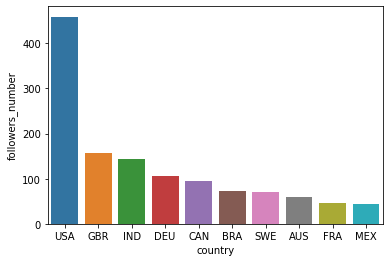

In [17]:
country_count_df = follower_analyzer.count_followers_per_country(df)
#sns.barplot(x = 'country', y = 'followers_number', data = country_count_df[:10])
#plt.savefig('.png', format='png')
follower_analyzer.bar_plot_followers_distribution(country_count_df[:10], 'bar_followers_distribution')

In [18]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world[world['iso_a3'].str.contains('-99')]

In [19]:
df_new = follower_analyzer.missing_values_handling(world)
x = df_new[['name', 'iso_a3', 'geometry']]
df_merged = x.join(country_count_df.set_index('country'), on='iso_a3')
df_merged['followers_number'] = df_merged['followers_number'].fillna(0)

In [20]:
x = set(df_merged[df_merged['followers_number']==0].sort_values('iso_a3',inplace=False, ascending=False)['iso_a3'])
y = set(country_count_df.sort_values('followers_number',inplace=False, ascending=False)['country'])

In [21]:
len(x)

82

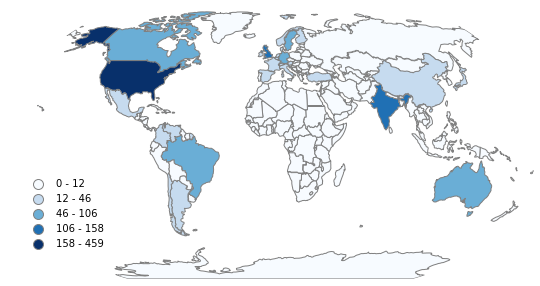

In [23]:
follower_analyzer.plot_map(df_merged, gplt.crs.Robinson(), (0.20, 0.40),
                           'Blues', 'FisherJenks', 'wolrd_followers_map')

C:\Users\amerk\Anaconda3\lib\site-packages\geoplot\geoplot.py:720: UserWarning: Cound not set plot extent successfully due to numerical instability. Try setting extent manually. Defaulting to a global extent.
  'Cound not set plot extent successfully due to numerical instability. '


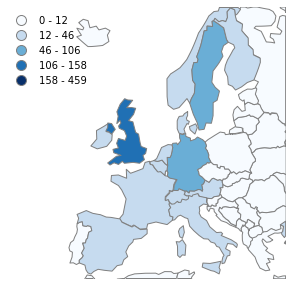

In [24]:
follower_analyzer.plot_map(df_merged, gplt.crs.EuroPP(), (0.20, 1),
                           'Blues', 'FisherJenks', 'europe_followers_map')

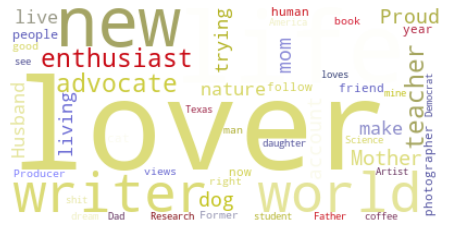

In [25]:
usa_description = df[df['country'].str.contains('USA') & df['description'].notnull()]['description']
stop_words = ['love', 'music', 'Tweet', 'Tweets', 'one']
follower_analyzer.world_cloud(usa_description, 'world_cloud_usa_profile_description', False, 'gist_stern_r', stop_words)

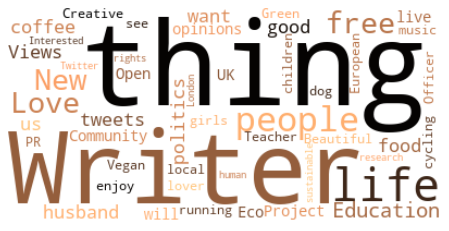

In [26]:
gbr_description = df[df['country'].str.contains('GBR')& df['description'].notnull()]['description']
follower_analyzer.world_cloud(gbr_description, 'world_cloud_gba_profile_description', False, 'copper')

In [27]:
#world_cloud(df[df['country'].str.contains('IND')& df['description'].notnull()]['description'])

In [28]:
#world_cloud(df[df['country'].str.contains('AUT')& df['description'].notnull()]['description'])

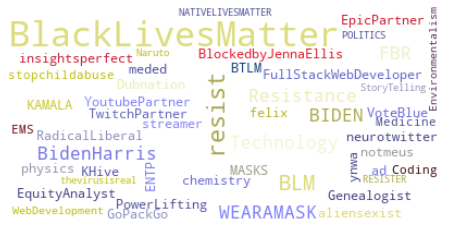

In [29]:
follower_analyzer.world_cloud(follower_analyzer.get_hashtags(usa_description).hashtags, 'world_cloud_usa_hashtags', True, 'gist_stern_r')

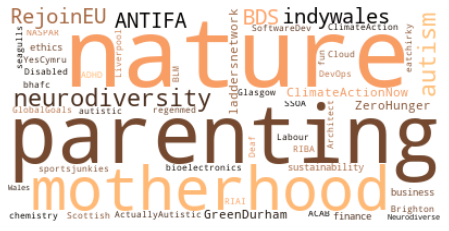

In [30]:
follower_analyzer.world_cloud(follower_analyzer.get_hashtags(gbr_description).hashtags, 'world_cloud_gbr_hashtags', True, 'copper')